In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


MOVIE_DIR="./images"

CREATE_MOVIE = False # True if you have ffmpeg installed

import training_models_helper
%aimport training_models_helper

tmh = training_models_helper.TrainingModelsHelper()

gdh = training_models_helper.GradientDescentHelper()

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

In [3]:
%run beautify_plots.py

In [4]:
import training_models_helper
%aimport training_models_helper

gdh = training_models_helper.GradientDescentHelper()

# Gradient Descent

Many problems in Machine Learning are framed as *optimization* problems
- Find the choice of parameters $\Theta$
- That minimizes a Loss function

The best (optimal) $\Theta$ is the one that minimizes the Average (across trainng examples) Loss

$$
\Theta^* = \argmin{\Theta} { \loss_\Theta }
$$

Many Classical ML problems are designed such that $\Theta^*$ has a closed-form solution
- Maximum likelihood estimates for Linear Regression

Closed form solutions, however, may only be feasible for  Loss function of restricted form.

When a closed form solution is not possible, we may find $\Theta^*$
via a search process known as Gradient Descent.

In the Deep Learning part of the course, virtually all Loss functions will require this form of solution.

## Loss functions, review

- $\hat{\y}^{(i)} = h(\x^\ip; \Theta)$, the predcition for example $\x^\ip$ with target label $\y^\ip$
- Per-example loss

$$
\loss^\ip_\Theta =  L( \;  h(\x^\ip; \Theta),  \y^\ip \;) = L( \hat{\y}^\ip , \y) 
$$

- The Loss for the entire training set is simply the average (across examples) of the Loss for the example

$$
\loss_\Theta  = { 1\over{m} } \sum_{i=1}^m \loss^\ip_\Theta
$$

Two common forms of $L$ are Mean Squared Error (for Regression) and Cross Entropy Loss (for classification).

# Optimiziation

How do we find the $\Theta^*$ that minimizes $\loss$ ?

$$
\Theta^* = \argmin{\Theta} { \loss_\Theta }
$$

One way is via a search-like procedure known as Gradient Descent:

We start with an initial guess for $\Theta$ and then:
- Evaluate $\loss_\Theta$ across training examples
$$ \langle \X, \y \rangle= [ \x^\ip, \y^\ip | 1 \le i \le m ]$$
- Make a *small change* to $\Theta$ that results in a reduced $\loss_\Theta$
- Repeat until $\loss_\Theta$ stops decreasing

Fortunately, for many functions $\loss_\Theta$ we can use calculus to
guide the small change in $\Theta$ in the direction of reduced $\loss_\Theta$

$$
\frac{\partial}{\partial \Theta} \loss_\Theta
$$

is the partial derivative of $\loss_\Theta$ with respect to $\Theta$.
- For a unit increase in $\Theta$: $\loss_\Theta$ *increases* by $\frac{\partial}{\partial \Theta} \loss_\Theta$



Thus, to *decreases* $\loss_\Theta$ we only need to add an increment in $\Theta$
propoprtional to 


Since $\Theta$ is a vector, the partial derivative is *also* a vector and is called the *gradient*.

The iterative process we described is called *gradient descent* as it follows the negative of the gradient
towards a minimum for $\Theta#.

Here is some illustrative code we will use to demonstrate the process.

In [5]:

def f(x):
    return x**2

def deriv(f,x_0):
    h = 0.000000001                 #step-size 
    return (f(x_0 +h) - f(x_0))/h 

def tangent(f, x_0, x=None):
    y_0 = f(x_0)
    slope = deriv(f, x_0)
    
    if x is not None:
        r = 2
        xmin, xmax = np.min(x), np.max(x)
        xlo, xhi = max(x_0 -r, xmin), min(x_0 +r, xmax)
    else:
        r = 2
        xlo, xhi = x_0 -r, x_0 + r
   
    xline = np.linspace(xlo, xhi, 10)
    yline = y_0 + slope*( xline - x_0)
    
    return xline, yline

def plot_tangent(f, x_s, x, ax, show_tangent=True):
    # Plot function
    _= ax.plot(x, f(x))

    # Plot tangent point x_s
    y_s = f(x_s)
    ax.scatter(x_s, y_s, color='r', s=90)

    # Plot tangent line
    if show_tangent:
        xtang, ytang = tangent(f, x_s, x)
        ax.plot(xtang, ytang, 'g--')
    
    return ax

In [6]:
def plot_step(f, x_s, x, show_tangent=True, visible=True):
    fig, ax = plt.subplots(1, 1, figsize=(12,6))

    y_s = f(x_s)
    
    # Plot the function, the point, and optionally: the tangent line
    _= plot_tangent(f, x_s, x, ax, show_tangent=show_tangent)
        
    _= ax.set_xlabel("$\Theta$", fontsize=16)
    _= ax.set_ylabel("$\mathcal{L}$", fontsize=16, rotation=0)
    
    if not visible:
        plt.close(fig)
        
    return fig, ax

In [7]:
def plot_gradient_descent(max_steps=4, alphas=[ 0.1, 0.4, 0.7, 1.0 ]):

    fig, axs = plt.subplots(len(alphas), max_steps, figsize=(20,min(12, 6 * len(alphas))))
    axs = axs.reshape( (len(alphas), max_steps) )  # Take care of special case where len(alpha) == 1

    for a_idx, alpha in enumerate(alphas):
        x_s = x_0

        for step in range(0,max_steps):
            ax = axs[a_idx, step]
            _= ax.set_xlabel("$\Theta$", fontsize=16)
            _= ax.set_ylabel("$\mathcal{L}$", fontsize=16, rotation=0)
            _= ax.set_title('$\\alpha$={a:3.2f}'.format(a=alpha))
            y_s = f(x_s)

            # Obtain tangent line at x0
            _= plot_tangent(f, x_s, x, ax) 

            # Update x_s
            slope = deriv(f, x_s)
            x_s = x_s + alpha * (- slope)

    _= fig.tight_layout()
    
    plt.close(fig)
    return fig, axs

In [8]:
alpha = 0.4
x = np.linspace(-5, +5, 30)


# Gradient Descent: Overview

Let's illustrate the process with an example

Let's plot a simple loss function as an illustration.

In this simple example: $\Theta$ is a vector of length 1.

In [9]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
_= ax.plot(x, f(x), linewidth=3)
_= ax.set_xlabel("$\Theta$", fontsize=16)
_= ax.set_ylabel("$\mathcal{L}$", fontsize=16, rotation=0)
plt.close(fig)

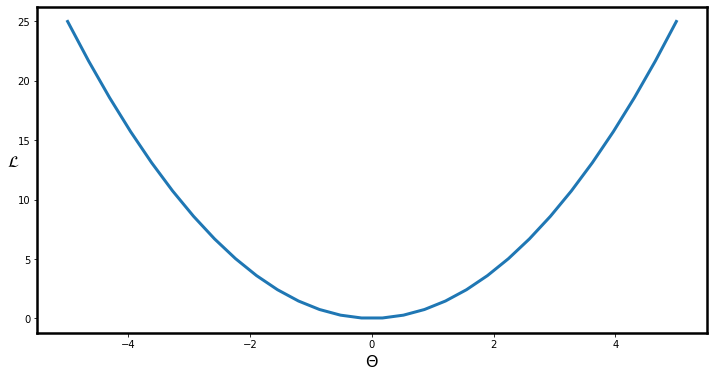

In [10]:
fig

Let's start off with a guess for $\Theta$

In [11]:
x_0 = 4
x_s = x_0

In [12]:
fig, ax = plot_step(f, x_s, x, show_tangent=False, visible=False)

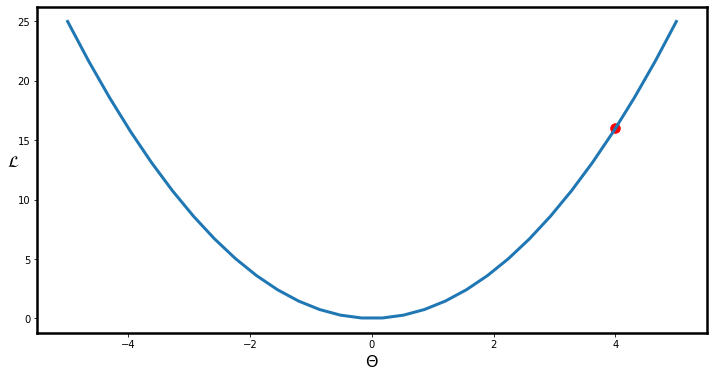

In [13]:
fig

Clearly not at a minimum.

Compute the gradient of $\loss_\Theta$ at initial guess $x_s$

In [14]:
x_s = x_0
fig, ax = plot_step(f, x_s, x, visible=False)

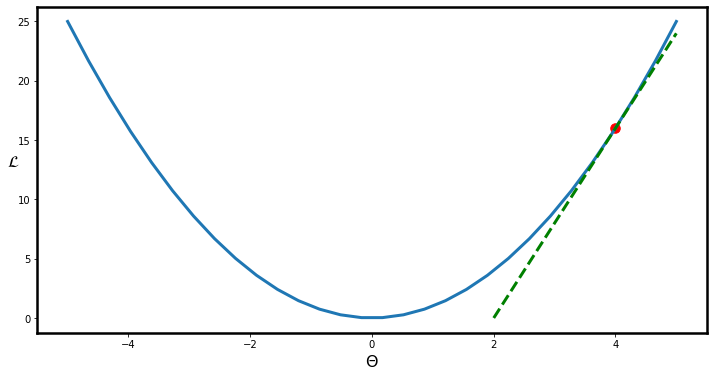

In [15]:
fig

Let's modify our guess by moving in proportion ($\alpha$) to the negative of the gradient:

In [16]:
# Update x_s
slope = deriv(f, x_s)
x_s = x_s + alpha * (- slope)
   

In [17]:
fig, ax = plot_step(f, x_s, x, show_tangent=False, visible=False)

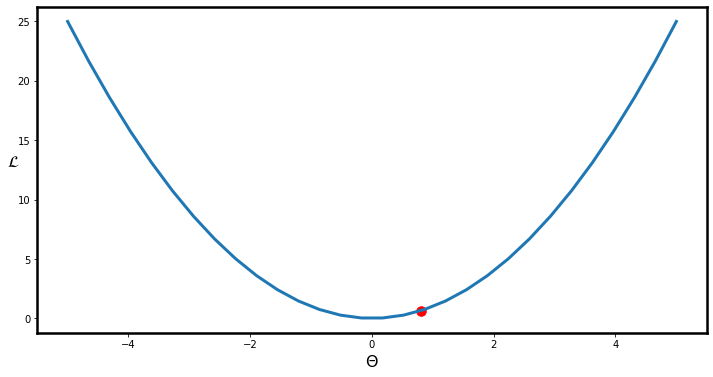

In [18]:
fig

By following the gradient as we did: we wind up at a new $\Theta$ where $\loss_\Theta$ is reduced compared ot that at the original guess.

Taking the gradient of the $\loss$ at the new point, we continue the iterative process.


In [19]:
if CREATE_MOVIE:
    _= gdh.create_gif2(x, f, x_0, out="images/gd.gif", alpha=alpha)

In [20]:
_= gdh.display_gif("images/gd.gif")

Image(value=b'GIF89a\xb0\x01 \x01\xf7\x00\x00\x00\x00\x00\x0e\x0e\x0e\x13\x13\x13\x1d\x1d\x1d$$$,,,222???\x00~…

In [21]:
fig, axs = plot_gradient_descent(alphas= [ alpha ])

Below we visualize the progress of the iterative procedure.

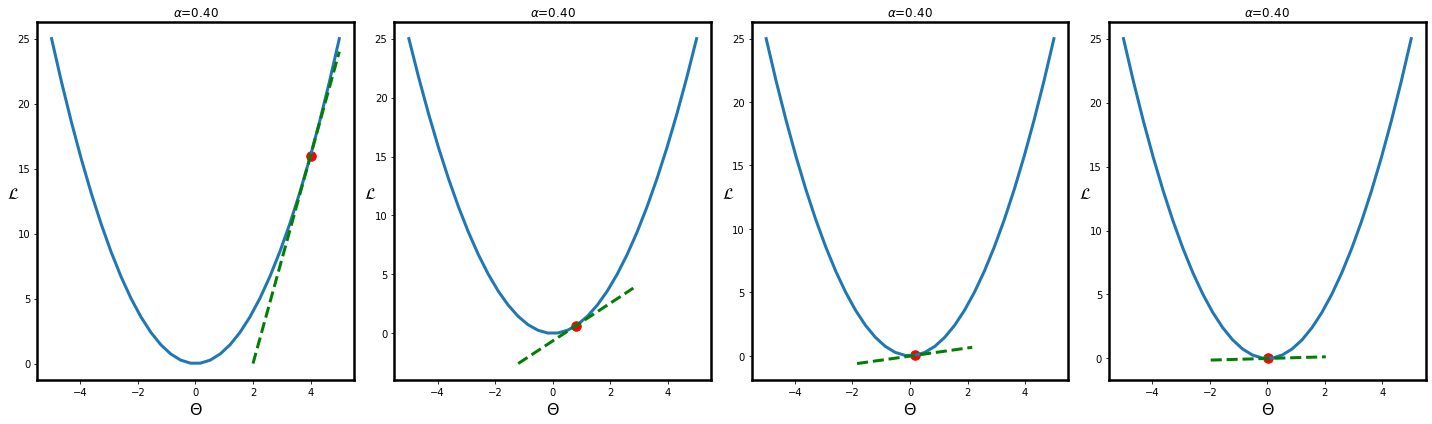

In [22]:
fig

# Gradients: vector derivatives

We illustrated the use of Gradient Descent to find the minimum of a function of a single variable.

The same procedure works when the function is of higher dimension.

Let's illustrate with the MSE Loss often used in Linear Regression, when
$\x^\ip$ (and hence $\Theta$) is of dimension $n$.

$$
\y = \Theta^T \cdot \x
$$



With $(n + 1)$ features (including the constant)
- $\Theta$ is a vector of length $(n+1)$
- $\frac{\partial}{\partial \Theta} \loss_\Theta = \nabla_\Theta \loss_\Theta$, is a vector of length $(n+1)$


$$
\nabla_\Theta \loss_\Theta =
\begin{pmatrix}
 \frac{\partial}{\partial \Theta_0} \loss_\Theta \\
 \frac{\partial}{\partial \Theta_1} \loss_\Theta\\
 \vdots \\
 \frac{\partial}{\partial \Theta_n} \loss_\Theta
\end{pmatrix}
$$

Using MSE Loss as the Loss function
$$
\loss_\Theta = \text{MSE}(\y, \hat{\y}, \Theta) = { 1\over{m} } \sum_{i=1}^m (  \y^\ip  - \hat{\y}^\ip )^2
$$


$$
\nabla_\Theta \loss_\Theta =
\begin{pmatrix}
 \frac{\partial}{\partial \Theta_0} \text{MSE}(\y, \hat{\y}, \Theta) \\
 \frac{\partial}{\partial \Theta_1} \text{MSE}(\y, \hat{\y}, \Theta) \\
 \vdots \\
 \frac{\partial}{\partial \Theta_n} \text{MSE}(\y, \hat{\y}, \Theta)
\end{pmatrix}
$$

Whereas in our illustration
- We compute derivatives *numerically*
- We will compute them below *analytically*, using calculus

Analytic (closed form) derivatives are much faster to compute.
- During the Deep Learning part of the course, we will see how to *automatically* obtain analytic derivatives

$$
\begin{array}{lll}\\
 \frac{\partial}{\partial \Theta_j} \text{MSE}(\y, \hat{\y}, \Theta) & = &
{ 1\over{m} } \sum_{i=1}^m  \frac{\partial}{\partial \Theta_j} (  \y^\ip  - \hat{\y}^\ip )^2 & \text{definiiton}\\
& = & { 1\over{m} } \sum_{i=1}^m  {2 * (  \y^\ip  - \hat{\y}^\ip ) \frac{\partial}{\partial \Theta_j}} \hat{\y}^\ip & \text{chain rule}\\
& = & { 1\over{m} } \sum_{i=1}^m  {2 * (  \y^\ip  - \hat{\y}^\ip ) \frac{\partial}{\partial \Theta_j}} (\Theta * \x^\ip) & \hat{\y}^\ip = \Theta^T \cdot \x^\ip\\
& = & { 1\over{m} } \sum_{i=1}^m  {2 * (  \y^\ip  - \hat{\y}^\ip ) \x^\ip_j}   \\
& = & { 2 \over{m} } \sum_{i=1}^m  { (  \y^\ip  - \hat{\y}^\ip ) \x^\ip_j}   \\
\\
\end{array}
$$

Thus the gradient for Linear Regression can be written in matrix form as

$
\nabla_{\boldsymbol{\theta}}\, \text{MSE}(X, \boldsymbol{\theta}) =
 = \dfrac{2}{m} \X^T ( \theta^T \X - \mathbf{y})
$

This will be particularly useful when working with NumPy as the gradient calculation is a vector operation that is implemented so as to be fast.

# Gradient Descent versus MLE

For Linear Regression, there is a closed form solution for finding the optimal $\Theta$.

We will demonstrate that the Gradient Descent search comes arbitrarily close.


Let's illustrate Batch Gradient Descent on an example.

First, we use sklearn's `LinearRegression` as a baseline against which we will compare the $\Theta$ obtained from
Gradient Descent.

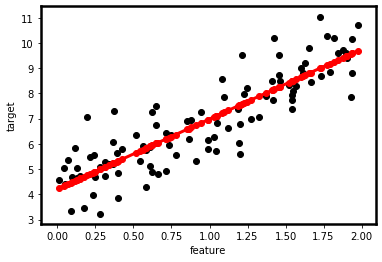

In [23]:
X_lr, y_lr = gdh.gen_lr_data()
clf_lr = gdh.fit_lr(X_lr,y_lr)
fig, ax = gdh.plot_lr(X_lr, y_lr, clf_lr)

theta_lr = (clf_lr.intercept_, clf_lr.coef_)

Now let's perform Batch Gradient Descent and compare the $\Theta$'s

In [24]:
gd_theta = gdh.batchGradientDescent_lr(X_lr, y_lr)
theta_lr - gd_theta

array([[7.993605777301127e-15],
       [-8.43769498715119e-15]], dtype=object)

The $\Theta$'s are equal up to 15 decimal points.

Let's look at the code for Batch Gradient Descent and examine the details

- We use the closed form, analytic expression for the gradient
- We update
$$
\Theta = \Theta - \alpha * \text{gradient}
$$


Notice that the "step size" ($\alpha * \text{gradient}$)
- Is "big" when the gradient is large
- Is "small" when the gradient is small (close to optimal)



Since the $\Theta$'s computed by Gradient Descent and Linear Regression are the same, it's no surprise that the predictions are too.
- as demonstrated in the following code

In [25]:
X_new = np.array([[0], [2]])
gd_y_pred = gdh.predict(X_new, theta_lr)
clf_y_pred = clf_lr.predict(X_new)

gd_y_pred == clf_y_pred

array([[ True],
       [ True]])

# Gradient Descent in depth

There are many subtleties to Gradient Descent.

As Gradient Descent will be a *key tool* in the Deep Learning part of the course, we briefly
explore a few issues below.

## How big should $\alpha$ be ?

The "step size" we take along the direction of the gradient is $\alpha$.

Does the choice of $\alpha$ matter ?

Here are 4 steps with $\alpha = 0.40$

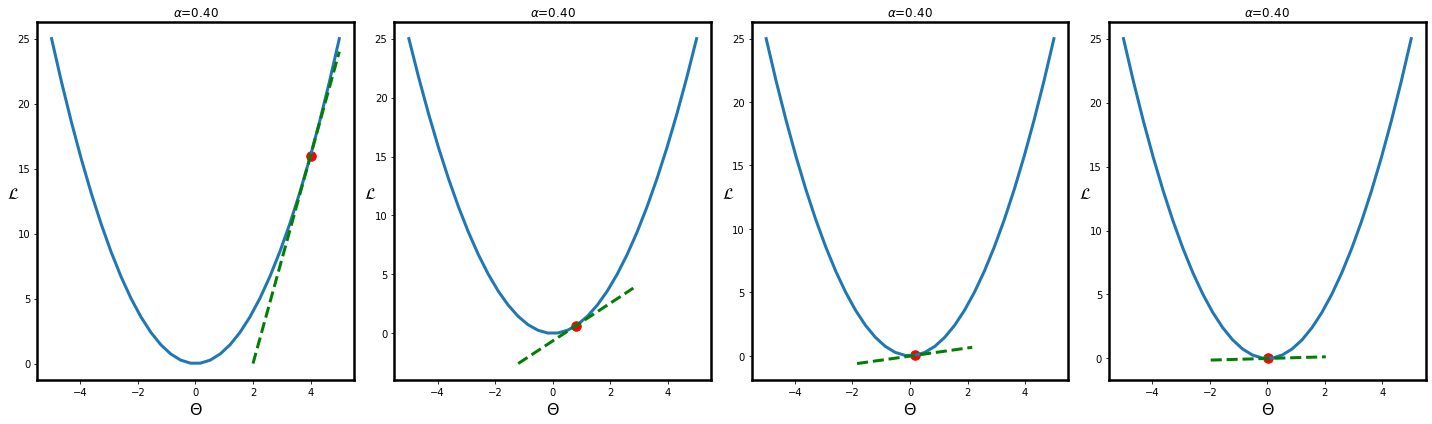

In [26]:
fig, axs = plot_gradient_descent(alphas= [ alpha ])
fig

And with a much smaller $\alpha = 0.1$

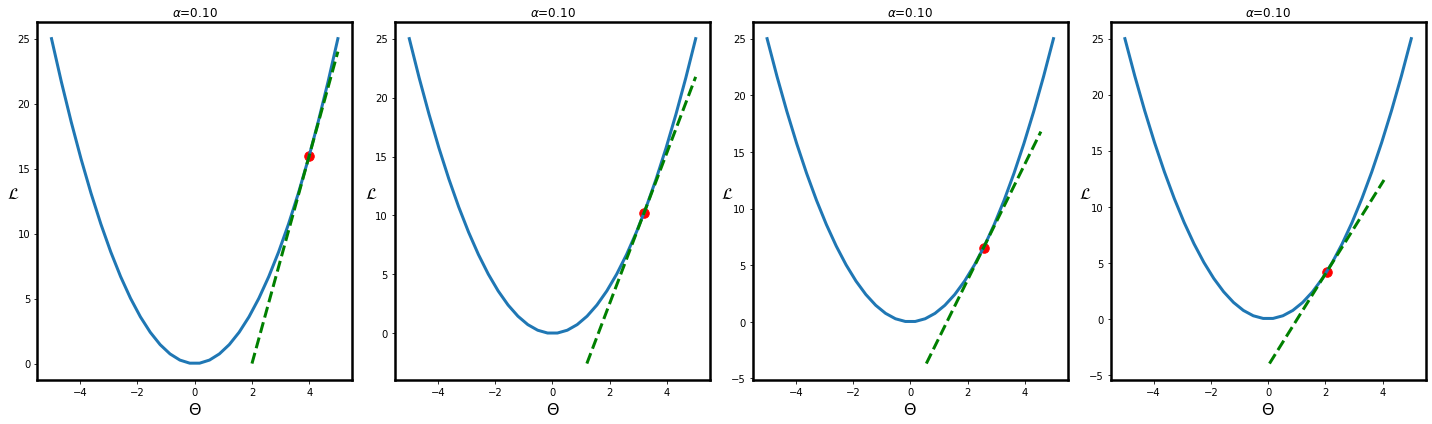

In [27]:
fig, axs = plot_gradient_descent(alphas= [ 0.1 ])
fig

Convergence toward the optimal is much slower.

What if we used a largeer $\alpha = 0.9$ ?

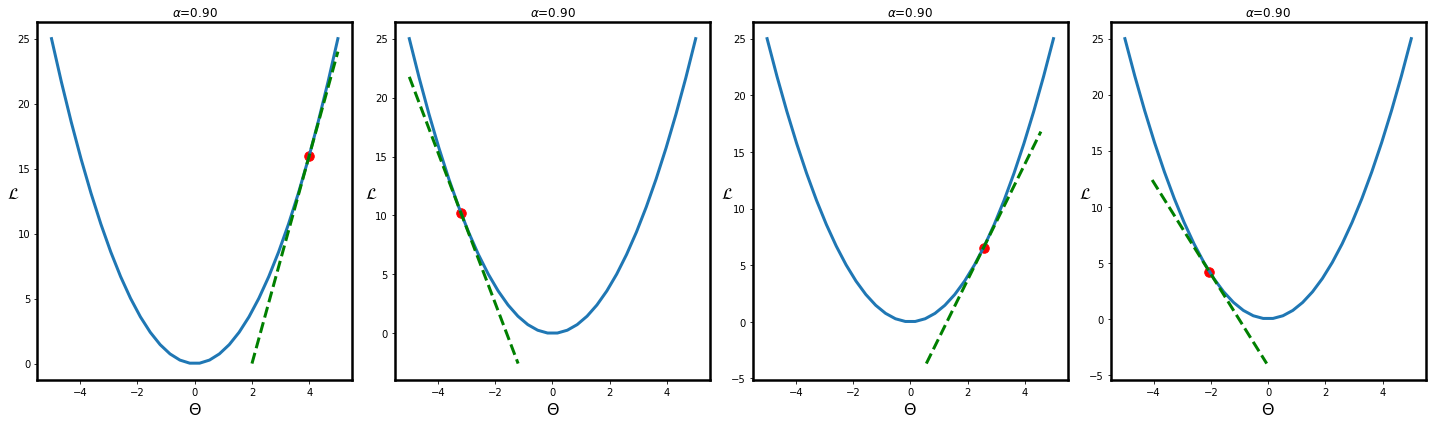

In [28]:
fig, axs = plot_gradient_descent(alphas= [ 0.9 ])
fig

You can see that we over-shoot the optimal repeatedly.

This may be problematic
- For more complex loss functions: we may "skip" over a local optimium

An adaptive learning rate schedule may be the solution:
- take big steps at first
- take smaller steps toward end

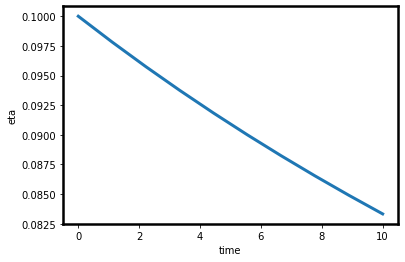

In [29]:
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

t = np.linspace(0, 10, 10)

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_ =ax.plot(t, learning_schedule(t))
_ = ax.set_xlabel("time")
_ = ax.set_ylabel("eta")

We will revisit Learning Rate schedules in the Deep Learning part of the course.

## Minibatch Gradient Descent

The Average Loss function in Classical Machine Learning has the form

$$
    \loss_\Theta = \frac{1}{m} \sum_{i=1}^m \loss_\Theta^\ip
$$

That is, it is composed of $m$ sub-expressions where $m$ is the number of training examples.
- Each subexpression requires a computation and a derivative

Thus, for large sets of training examples, Gradient Descent can be expensive.

It may be possible to *approximate* $\loss_\Theta$ using fewer than $m$ expressions.

- Choose a *random subset ( of size $m' \le m$)* of  examples: $I = \{ i_1, \ldots, i_{m'} \}$
- Approximate $\loss_\Theta$ on $I$
$$
\loss_\Theta \approx \frac{1}{|I|}\sum_{i \in I} \loss_\Theta^\ip
$$

This means it is possible to update $\Theta$ after evaluating only $m\ \le m$ expressions.


Whereas Gradient Descent computes an exact $\loss_\Theta$ to perform a single update of $\Theta$:

*Minibatch Gradient Descent*
- takes $b = m/m'$ smaller steps, each updating $\Theta$
- each small step using an approxmation of $\loss_\Theta$ based on $m' \le m$ examples


It does this by
- choosing batch size $m'$
- partitioning the set of example indices $\{i | 1 \le i \le m \}$
    - into $b$
    *batches* of size $m'$
    - batch $i': b_{(i')}$ is one partition consisting of $m'$ example indices
    - Each small step uses a single batch to approximate $\loss_\Theta$ and update $\Theta$

The collection of $b$ small steps (comprising all examples) is called an *epoch*

So one epoch of Minibatch Gradient Descent performs $b$ updates.

When batch size $m' = m$, we have our original algorith known as *Batch Gradient Descent*.

How does one choose $m' \le m$ ?
- Want $m'$ large enough so approximations aren't too noisy
    - Don't want losses of the mini-batches of each epoch to be too different
- Often determined by *external* considerations
    - GPU memory (preview of Deep Learning)

## Initializing $\Theta$

As we will see in the Deep Learning part of the course
- Initial $\Theta$ is *not a trivial* choice

Consider a Loss function like the Hinge Loss
- Our initial choice of $\Theta$ could leave us in a *flat* area of the Loss function
- No derivative, but maybe not optimal
- No way to escape !


## When to stop

Deciding when to stop the iterative process is another choice to be made
- Stop when decrease in $\loss_\Theta$ is "too small"


# Improvements to Gradient Descent

[Simon Ruder survey](https://arxiv.org/abs/1609.04747)

[Gradient Descent Cheatsheet](https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9)

The update step
$$
\Theta = \Theta - \alpha * \frac{\partial \loss_\Theta }{\partial \Theta}
$$


where $\alpha$ is the learning rate.

The improvements to Gradient Descent modify
- $\alpha$, the learning rate
- $\frac{\partial \loss_\Theta }{\partial \Theta}$ the gradient

In order to be able to flexibly change the definiton of both the gradient and the learning rate
at each time step $t$,
e will re-write the update step at time $t$ as

$$
\Theta_\tp = \Theta_{(t-1)} -  \alpha' * V_\tp
$$

$V_\tp$ will be our modified gradient and $\alpha'$ our modified learning rate.

## Momentum: modify the gradient

In vanilla Gradient Descent, the gradients at time $t-1$ and time $t$ are completely independent.

This has the potential for gradients to rapidly change direction (recall, they are a vector).

To smooth out jumps we could compute a modified gradient $V_\tp$ as:
$$
V_\tp = \beta_V * V_{(t-1)} + (1 - \beta_V) * \frac{\partial \loss_\Theta }{\partial \Theta}
$$

(Initialize $V_0 = 0$)

That is, the modified gradient is a weighted combination of the previous gradient and the new gradient.

Typically $\beta_V \approx 0.9$ so the old gradient dominates.

$V_\tp$ is the exponentially weighted moving average of the gradient.

Hence, there is "momentum" in the gradients in that they can't jump suddenly.

## RMSprop: Modify the learning rate

Let
$$
S_\tp = \beta_S * S_{(t-1)} + (1 -\beta_S) * \left( \frac{\partial \loss_\Theta }{\partial \Theta} \right)^2
$$

That is, $S_\tp$ is the exponentially weighted *variance* of the gradient.

(Initialize $S_0 = 0$)

Rather than using a learning rate of $\alpha$, the RMSprop algorithm uses
$$
\alpha' = \frac{1}{\sqrt{S_\tp + \epsilon}} * \alpha
$$

The intuition is that if the gradient with respect to $\Theta_j$ is noisy (i.e., large variance)
we want to damp updates in that component.

This also has the advantage that a rarely updated element $\Theta_i$, having a low variance,
will have a relatively larger update when it is encountered than a more frequently encountered feature.

Typically $\beta_S \approx 0.9$ so the old variance dominates.

Why the extra $\epsilon$ ?  We've seen this before (e.g., $\log(x + \epsilon)$):
it's to avoid mathematical issues of certain functions (inverse, log) when the argument is $0$.

## AdaM: Modify both the gradient and the learning rate

The AdaAM (Adaptive Moment) algorithm modifies both the gradient and learning rates via
exponentially moving averages of the gradient as well as its variance.

$$
\begin{array}[lll] \\
V_\tp = \beta_V * V_{(t-1)} + (1 - \beta_V) \frac{\partial \loss_\Theta }{\partial \Theta} \\
S_\tp = \beta_S * S_{(t-1)} + (1 -\beta_S) * \left( \frac{\partial \loss }{\partial \Theta} \right)^2 \\
\alpha' = \frac{1}{\sqrt{S_\tp + \epsilon}} * \alpha
\end{array}
$$

### Bias correction

You will have observed that we initialized to $0$ the moving averages for gradients ($V_0 = 0$) and
the variance of the gradients ($S_0 = 0$).

So the values are "biased" towards 0 with the bias having greatest effect for small $t$ (i.e., when the number
of "actual" values is small).

We can correct for the bias by dividing by $(1 - \beta^t)$:

$$
\begin{array}[lll] \\
\hat{V} & = & \frac{V_\tp}{1 - \beta_V^t} \\
\hat{S} & = & \frac{S_\tp}{1 - \beta_S^t} \\
\end{array}
$$

In [30]:
print("Done")

Done
